# TM10007 Assignment template

In [21]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git

  Preparing metadata (setup.py) ... done


## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [22]:
# Data loading functions. Uncomment the one you want to use
#from worcgist.load_data import load_data
#from worclipo.load_data import load_data
from worcliver.load_data import load_data
#from ecg.load_data import load_data

data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 186
The number of columns: 494


**Checking for missing data**

In [23]:
# A test if missing data is found correctly
# print(data.iloc[5:8, 1:2])
# data.iloc[5:8, 1:2] = None
# print(data.iloc[5:8, 1:2])

# Checking for missing data, returning specific column and row that is missing
missing_data_total = data.isna().sum().sum()
rows_with_missing = data[data.isna().any(axis=1)]
print(f'Total amount of missing data: {missing_data_total}')
for index, row in rows_with_missing.iterrows():
    missing_columns = row[row.isna()].index
    print(f"Data missing in row: {index}, and column: {', '.join(missing_columns)}")

# check for duplicate features
duplicate_columns = data.columns[data.columns.duplicated()]
if len(duplicate_columns) > 0:
    print("Duplicate column names:")
    print(duplicate_columns)
else:
    print("No duplicate columns found.")

Total amount of missing data: 0
No duplicate columns found.


**Imports**

Import all modules necessary for this Jupyter Notebook


In [24]:
import numpy as np
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import datasets as ds
from sklearn.model_selection import GridSearchCV

#feature Selection
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

# Classifiers
from sklearn import model_selection
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn import decomposition

# Metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Basic and complex Classifiers
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.kernel_approximation import RBFSampler
from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV

**Definitions applied in this Jupyter Notebook**

In [25]:
def colorplot(clf, ax, x, y, h=100, precomputer=None):
    '''
    Overlay the decision areas as colors in an axes.

    Input:
        clf: trained classifier
        ax: axis to overlay color mesh on
        x: feature on x-axis
        y: feature on y-axis
        h(optional): steps in the mesh
    '''
    # Create a meshgrid the size of the axis
    xstep = (x.max() - x.min() ) / 20.0
    ystep = (y.max() - y.min() ) / 20.0
    x_min, x_max = x.min() - xstep, x.max() + xstep
    y_min, y_max = y.min() - ystep, y.max() + ystep
    h = max((x_max - x_min, y_max - y_min))/h
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    features = np.c_[xx.ravel(), yy.ravel()]
    if precomputer is not None:
        if type(precomputer) is RBFSampler:
            features = precomputer.transform(features)
        elif precomputer is rbf_kernel:
            features = rbf_kernel(features, X)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(features)
    else:
        Z = clf.predict_proba(features)
    if len(Z.shape) > 1:
        Z = Z[:, 1]

    # Put the result into a color plot
    cm = plt.cm.RdBu_r
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap=cm, alpha=.8)
    del xx, yy, x_min, x_max, y_min, y_max, Z, cm


**Data Visualization**

In [ ]:
#Describe the data
df_data = pd.DataFrame(data)
X = df_data.iloc[:, 1:]  # Feature set
y = df_data.iloc[:, :1]  # Classification Benign/Malignant
data.info()
data.describe()

###Data Visulaisation
# Plot the division of malignant and benign tumors
data.groupby('label').size().plot(kind='barh', figsize=(6, 4), color=['skyblue', 'salmon'], edgecolor='black')  # Adjust colors and add edgecolor for better distinction
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('Count', fontsize=14)  # Increase font size for better readability
plt.ylabel('Label', fontsize=14)
plt.title('Division of Malignant and Benign Tumors', fontsize=16)  # Increase title font size
plt.xticks(fontsize=12)  # Increase font size of x-axis ticks
plt.yticks(fontsize=12)  # Increase font size of y-axis ticks
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

#Correlation matrix and heatmap
numeric_columns = df_data.select_dtypes(include=[np.number]).columns
numeric_df = df_data[numeric_columns]
correlation_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
seaborn.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Features', fontsize=16)
plt.xticks(fontsize=5)
plt.yticks(fontsize=5)
plt.tight_layout()
plt.show()
#Strong Correlation = bright colour
#Positive correlation = +1
#Negative correlation = -1

# Calculate and visualize the variance of each feature
feature_variances = np.var(X, axis=0)

plt.figure(figsize=(6, 4))
plt.hist(feature_variances, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Variance', fontsize=8)
plt.ylabel('Frequency', fontsize=8)
plt.title('Distribution of Feature Variances', fontsize=12)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlim(50,(0.5*(10**23)))
plt.ylim(0, 200)
plt.tight_layout()
plt.show()

high_variance_features = np.where(feature_variances > (10**22))
print("high_variance_features")
print(high_variance_features)



**PRE PROCESSING**

Pre processing contains the following: ...

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, StratifiedKFold

# Pre processing
#
# Splitting
df_data = pd.DataFrame(data)
X = df_data.iloc[:, 1:]  # Feature set
y = df_data.iloc[:, :1]  # Classification Benign/Malignant

# Change classification (Benign/Malignant) to binary values
y['label'] = y.replace({'benign': 0, 'malignant': 1})

# Stratified K-Fold Split
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=40)

# Splitting data in Test and Train set
for train_index, test_index in skf.split(X, y):
    X_pre_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_pre_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Splitting data in Train and validation set
for train_index, test_index in skf.split(X_pre_train, y_pre_train):
    X_train, X_val = X.iloc[train_index], X.iloc[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]

# print(y_train)
print(f'The number of train samples: {len(y_train)}')
print(f'The number of validation samples: {len(y_val)}')
# print(f'test{y_test}')
print(f'The number of test samples: {len(y_test)}')
# print(f'val{y_val}')

**Scaling**

In [ ]:
# Scaling

# # General packages
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn import datasets as ds
# import seaborn

# # Classifiers
# from sklearn import model_selection
# from sklearn import metrics
# from sklearn import feature_selection
# from sklearn import preprocessing
# from sklearn import neighbors
# from sklearn import svm

# from sklearn import decomposition

# Scale the data to be normal
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
print(X_train_scaled)

# Omzetten data naar list
y_train_scaled = y_train['label'].values

y_train_list = y_train['label'].tolist()
y_val_list = y_val['label'].values
y_test_list = y_test['label'].values

# # Feature selection
# # Create the RFE object and compute a cross-validated score.
# svc = svm.SVC(kernel="linear")

# # classifications
# rfecv = feature_selection.RFECV(
#     estimator=svc, step=1,
#     cv=model_selection.StratifiedKFold(4),
#     scoring='roc_auc')
# rfecv.fit(X, y)

# # Plot number of features VS. cross-validation scores
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(rfecv.cv_results_["mean_test_score"]) + 1), rfecv.cv_results_["mean_test_score"])
# plt.show()

# # Perform a PCA
# pca = decomposition.PCA(n_components=2)
# pca.fit(X_train_scaled)
# X_train_pca = pca.transform(X_train_scaled)
# X_val_pca = pca.transform(X_val_scaled)
# X_test_pca = pca.transform(X_test_scaled) #Waarom staat hier de test set???, je fit de pca op de train set en past het toe op de val en test set -Luuk

# y_train_list = y_train['label'].tolist()
# y_val_list = y_val['label'].values
# print(y_train_list)
# print(X_train_pca)


##Evaluate scalling by calculating the feature variance
feature_variances = np.var(X_train_scaled, axis=0)

plt.figure(figsize=(8, 6))
plt.hist(feature_variances, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Variance', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Feature Variances', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Feature Selection

##Supervised feature selection

###Embedded methods

**L1 Regularization LASSO \(least absolute shrinkage and selection operator)**

*Applies a penalty to the absolute size of the features, forcing some of them to be exactly zero. Resulting in a subset of the features to contribute in the algorithm by eliminating irrelevant features from the model indicating that these features are not contributing significantly to the model's predictive power.*

In [ ]:
### This method now prints the features selected with the lasso method to predict maligne of benigne
from sklearn.linear_model import LassoCV
from sklearn.metrics import accuracy_score

# Compute ideal alpha for Lasso feature selection using cross-validation
lasso_cv = LassoCV(cv=5)
lasso_cv.fit(X_train_scaled, y_train_scaled)
ideal_alpha = lasso_cv.alpha_

# Fit the model to training data
lasso = Lasso(alpha=ideal_alpha)  # 'alpha' is the regularization (= prevent overfitting) strength, higher values indicate stronger regularization
lasso.fit(X_train_scaled, y_train_list)

# Print selected features to be non-zero
selected_features_lasso = X.columns[lasso.coef_ != 0] #selects the features used in the model and thus relevant for predictions
print("Selected Features:", selected_features_lasso)

# Create an Array containing only the selected features from the train data
selected_train_features_lasso_df = pd.DataFrame(X_train_scaled[:, lasso.coef_ != 0], columns=selected_features_lasso)
X_train_lasso = X_train_scaled[:, lasso.coef_ != 0]
y_train_scaled_df = pd.DataFrame(y_train_list, index=selected_train_features_lasso_df.index, columns=['Tumor'])
y_train_lasso = y_train_scaled_df.values

#print(f'y train lasso: {y_train_lasso}')
#print(f'x train lasso: {X_train_lasso}')

# Create an Array containing only the selected features from the validation data
selected_val_features_lasso_df = pd.DataFrame(X_val_scaled[:, lasso.coef_ != 0], columns=selected_features_lasso)
X_val_lasso = X_val_scaled[:, lasso.coef_ != 0]
y_val_scaled_df = pd.DataFrame(y_val_list, index=selected_val_features_lasso_df.index, columns=['Tumor'])
y_val_lasso = y_val_scaled_df.values

#print(f'y val lasso: {y_val_lasso}')
#print(f'x val lasso: {X_val_lasso}')

# Concatenate selected features DataFrame with y_train
selected_train_data = pd.concat([selected_train_features_lasso_df, y_train_scaled_df], axis=1)

# Now selected_train_data contains the values of the selected features in separate columns
print(selected_train_data.head())  # Display the first few rows of the selected train data

# Evaluate model performance
lasso_score = lasso.score(X_train_scaled, y_train_list)
print("Training Lasso Model Score:", lasso_score)

# Evaluate model performance
lasso_score = lasso.score(X_val_scaled, y_val_list)
print("Validation Lasso Model Score:", lasso_score)

**L2 Ridge Regularizaiton**


*Adds a penalty term proportional to the square of the coefficients,encourages smaller but non-zero coefficients for all features. Helps to reduce the impact of multicollinearity and stabilize the model meaning that when two features are highly correlated then one is given an smaller coefficient to prevent instability of the model estimates.*

In [ ]:
###This method now prints the features selected with the lasso method to predict maligne of benigne

# Fit the Ridge regression model to training data
ridge = Ridge(alpha=1)  # 'alpha' is the regularization strength, higher values indicate stronger regularization
ridge.fit(X_train_scaled, y_train_scaled)

#Print selected features (all features are used in Ridge regression)
selected_features_ridge = X.columns
print("Selected Features:", selected_features_ridge)

# Create a DataFrame containing all features from the test data
selected_train_features_ridge_df = pd.DataFrame(X_train_scaled, columns=selected_features_ridge)
y_train_scaled_df = pd.DataFrame(y_train_scaled, index=selected_train_features_ridge_df.index, columns=['Tumor'])

# Concatenate selected features DataFrame with y_train
selected_train_data = pd.concat([selected_train_features_ridge_df, y_train_scaled_df], axis=1)

# Now selected_train_data contains the values of all features along with the target variable
print(selected_train_data.head())  # Display the first few rows of the selected train data

# Visualize Ridge coefficients
def plot_coefficients(model, feature_names, title):
    coef = model.coef_.flatten()  # Coefficients need to be flattened for visualization
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_names)), coef, align='center')
    plt.xticks(range(len(feature_names)), feature_names, rotation=90)
    plt.xlabel('Feature')
    plt.ylabel('Coefficient Value')
    plt.title(title)
    plt.show()

plot_coefficients(ridge, X.columns, 'Ridge Coefficients')

# Evaluate model performance
ridge_score = ridge.score(X_train_scaled, y_train)
print("Ridge Model Score:", ridge_score)


###Wrapper methods (greedy selection)

**Forward selection**

*In forward selection, we start with a null model and then start fitting the model with each individual feature one at a time and select the feature with the minimum p-value. Now fit a model with two features by trying combinations of the earlier selected feature with all other remaining features. Again select the feature with the minimum p-value. Now fit a model with three features by trying combinations of two previously selected features with other remaining features. Repeat this process until we have a set of selected features with a p-value of individual features less than the significance level.*

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_predict
from mlxtend.feature_selection import SequentialFeatureSelector
import matplotlib.pyplot as plt
import pandas as pd

# Sequential Forward Selection (SFS)
sfs = SequentialFeatureSelector(
    RandomForestRegressor(),
    k_features=(1, 6),  # Selecting the number of best features
    forward=True,
    floating=False,
    scoring='r2',  # default
    cv=5  # Using cross-validation for evaluation
)

# Fit SFS on training data
sfs.fit(X_train_scaled, y_train_scaled)

# Get the performance metric (R-squared) for each number of features
metric_dict = sfs.get_metric_dict()

# Extracting the optimal number of features
optimal_num_features = sfs.k_feature_idx_

# Extracting the performance score (R-squared) for the optimal number of features
r2_optimal = metric_dict[optimal_num_features]['avg_score']

# Print the performance score
print("Performance Score (R-squared) for the optimal number of features:", r2_optimal)

# Plot feature selection process
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

# Extracting the names of the selected features
selected_feature_names = list(X.columns[list(optimal_num_features)])

# Creating a dataframe with the selected features
selected_features_df = pd.DataFrame({'Feature': selected_feature_names})
print("Selected features:")
print(selected_features_df)

# Fit the model with selected features
selected_features = X_train_scaled[:, optimal_num_features]
rf_model = RandomForestRegressor()
rf_model.fit(selected_features, y_train_scaled)

# Cross-validation predictions
cv_predictions = cross_val_predict(rf_model, selected_features, y_train_scaled, cv=5)

# Calculate evaluation metrics
r2 = r2_score(y_train_scaled, cv_predictions)
mae = mean_absolute_error(y_train_scaled, cv_predictions)
mse = mean_squared_error(y_train_scaled, cv_predictions)

# Print performance metrics
print("Performance Metrics on Training Set:")
print("R-squared:", r2)  # Predicts the fit of the model to the data
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

# Transform the validation set using the same preprocessing steps as the training set
X_val_scaled = scaler.transform(X_val)

# Select the same features that were selected during training
selected_features_val = X_val_scaled[:, optimal_num_features]

# Make predictions on the validation set
val_predictions = rf_model.predict(selected_features_val)

# Calculate evaluation metrics on the validation set
val_mae = mean_absolute_error(y_val_scaled, val_predictions)
val_mse = mean_squared_error(y_val_scaled, val_predictions)
val_r2 = r2_score(y_val_scaled, val_predictions)

# Print validation performance metrics
print("Validation Performance Metrics:")
print("Mean Absolute Error:", val_mae)
print("Mean Squared Error:", val_mse)
print("R-squared:", val_r2)


**Backward Elimination**

*In backward elimination, we start with the full model (including all the independent variables) and then remove the insignificant feature with the highest p-value(> significance level). This process repeats again and again until we have the final set of significant features.*

In [ ]:
#Sequential backward selection(sbs)
sbs = SFS(LinearRegression(),
         k_features=(1,X_train_scaled.shape[1]),
         forward=False,
         floating=False,
         cv=0)
sbs.fit(X_train_scaled, y_train_scaled)
sbs.k_feature_names_

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig2 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
plt.title('Sequential backward elimination (w. StdErr)')
plt.grid()
plt.show()

# Extracting the optimal number of features
optimal_num_features = sbs.k_feature_idx_
print(optimal_num_features)

# Extracting the names of the selected features
selected_feature_names = list(X.columns[list(optimal_num_features)])

# Creating a dataframe with the selected features
selected_features_df = pd.DataFrame({'Feature': selected_feature_names})
print("Selected features:")
print(selected_features_df)

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_predict

# Fit the Linear Regression model with selected features
selected_features = X_train_scaled[:, optimal_num_features]
lr_model = LinearRegression()
lr_model.fit(selected_features, y_train_scaled)

# Cross-validation predictions
cv_predictions = cross_val_predict(lr_model, selected_features, y_train_scaled, cv=5)

# Calculate evaluation metrics
r2 = r2_score(y_train_scaled, cv_predictions)
mae = mean_absolute_error(y_train_scaled, cv_predictions)
mse = mean_squared_error(y_train_scaled, cv_predictions)

# Print performance metrics
print("Performance Metrics:")
print("R-squared:", r2) #Predicts the fit of the model to the data
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

#Feature extraction

##PCA

*In PCA we try to create n composite features which can best represent the information contained in the number of features of our dataset. These n features are not original features, but developed as a combination of different already existing features.*

In [ ]:
#PCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define your pipeline with PCA followed by SVM
pipeline = Pipeline([
    ('pca', PCA()),
    ('clf', SVC())
])

# Define the hyperparameter grid for PCA and SVM
param_grid = {
    'pca__n_components': [1, 3, 5, 10, 15],  # Number of principal components
    'clf__C': [0.1, 1, 10],               # SVM regularization parameter
    'clf__gamma': [0.1, 0.01, 0.001],     # Kernel coefficient for RBF
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and model from the grid search
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Perform a PCA using the number of components found to be best
pca = best_model.named_steps['pca']
X_train_pca = pca.transform(X_train_scaled)

# Determine the ideal number of components using the elbow method
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
elbow_index = np.where(np.diff(cumulative_variance) < 0.05)[0]
if len(elbow_index) > 0:
    ideal_num_components = elbow_index[0] + 1  # Adjust for zero-based indexing
else:
    ideal_num_components = len(cumulative_variance)  # Use all components if no elbow found

# Use the determined number of components for PCA
pca = PCA(n_components=ideal_num_components)
X_train_pca = pca.fit(X_train_scaled)

# Transform the datasets using the fitted PCA
X_train_pca = pca.transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)


print("Ideal number of PCA components:", ideal_num_components)

# # Optionally, print out the transformed data to see the result
# print("Transformed Training Data:\n", X_train_pca)
# print("Transformed scaled Data:\n", X_train_scaled)
# print("Transformed Validation Data:\n", X_val_pca)
# print("Transformed Test Data:\n", X_test_pca)

Best Parameters: {'clf__C': 10, 'clf__gamma': 0.001, 'pca__n_components': 15}
Ideal number of PCA components: 4


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Classifiers

**Basic Classifiers**

Number of mislabeled points out of a total 120 points : 59


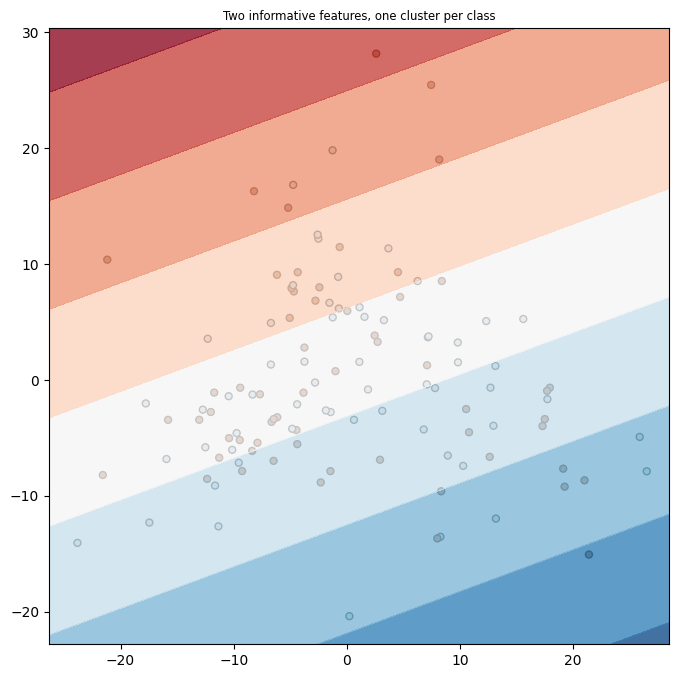

In [ ]:
# # General packages
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn import datasets as ds
# from sklearn import metrics

# # Metrics
# from sklearn.metrics import confusion_matrix
# from sklearn.metrics import mean_absolute_error
# from sklearn.metrics import r2_score

# # Basic Classifiers
# from sklearn.naive_bayes import GaussianNB
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
# from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from sklearn.linear_model import LogisticRegression
# from sklearn.linear_model import SGDClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier

# Linear classifier
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.set_title("Two informative features, one cluster per class",
             fontsize='small')
ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], marker='o', c=y_train_list,
           s=25, edgecolor='k', cmap=plt.cm.Paired)
lda = LinearDiscriminantAnalysis()
lda = lda.fit(X_train_pca, y_train_list)
y_pred = lda.predict(X_train_pca)
colorplot(lda, ax, X_train_pca[:, 0], X_train_pca[:, 1])
print("Number of mislabeled points out of a total %d points : %d" % (X_train_pca.shape[0], (y_train_list != y_pred).sum()))


**Basic classifiers: Gaussian, LDA, QDA, Logistic regression, SDG, KNN & Decision Tree**

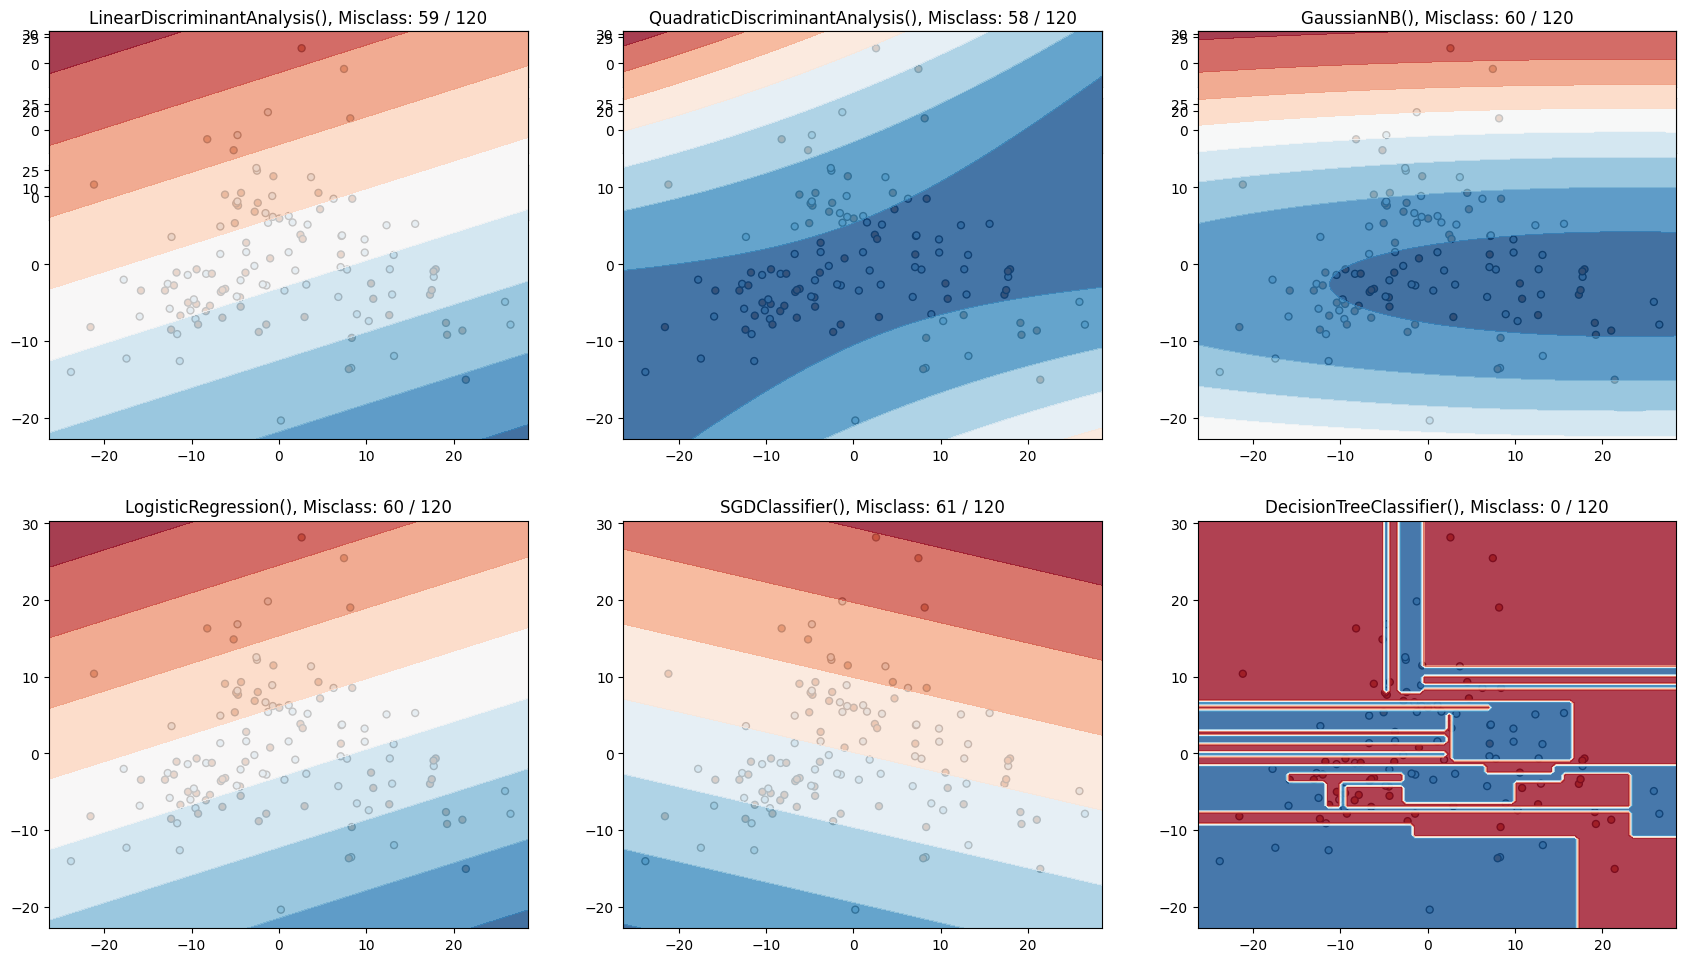

In [ ]:
# Plot several basic classifiers and plot the result. Define misclasses
clsfs = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),GaussianNB(),
         LogisticRegression(),SGDClassifier(),DecisionTreeClassifier()]
Xs = X_train_pca
Ys = y_train_list
clfs_fit = list()

# First make a plot without classifiers:
fig = plt.figure(figsize=(21,3*len(clsfs)))
num = 0  # Iteration number for the subplots

for num in range(0,7):
    ax = fig.add_subplot(21, 3, num + 1)
    ax.scatter(Xs[:, 0], Xs[:, 1], marker='o', c=Ys,
            s=25, edgecolor='k', cmap=plt.cm.Paired)

# Fit the classifiers and add them to the plot
num=0
Xt=list()
Yt=list()
for clf in clsfs:
    # Fit classifier
    clf.fit(Xs,Ys)
    y_pred=clf.predict(Xs)
    # Predict labels using fitted classifier

    # Make scatterplot of features
    ax = fig.add_subplot(3, 3, num + 1)
    ax.scatter(Xs[:, 0], Xs[:, 1], marker='o', c=Ys,
            s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, Xs[:,0], Xs[:,1])
    # Add overlay through colorplot function
    t=(f"{clf}, Misclass: %d / %d" % ((Ys!=y_pred).sum(), Xs.shape[0]))
    ax.set_title(t)
    num+=1

    clfs_fit.append(clf)
    Xt.append(Xs)
    Yt.append(Ys)


**KNN**

Best parameters: {'algorithm': 'brute', 'n_neighbors': 7, 'p': 2, 'weights': 'distance'}
training Accuracy: 1.0
Validation Accuracy: 0.6551724137931034


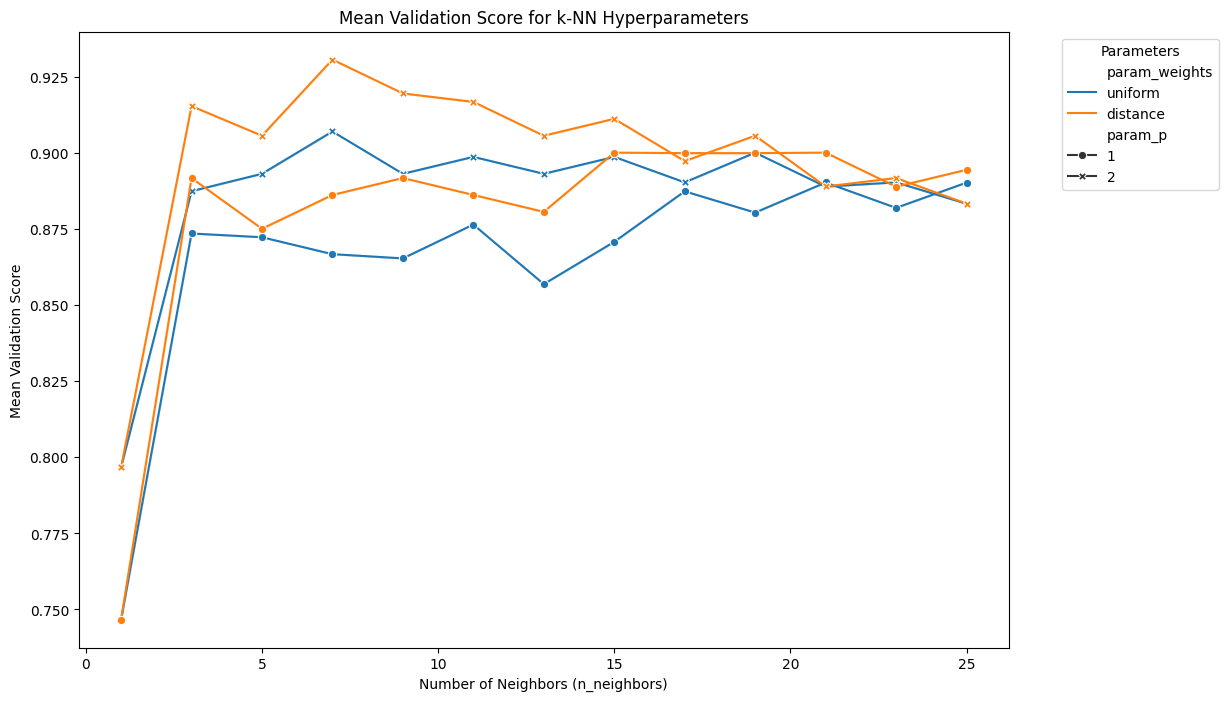

In [ ]:
# from sklearn.metrics import roc_auc_score
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import accuracy_score

# Define parameter grid
param_grid = {
    'n_neighbors': list(range(1, 26, 2)),
    'weights': ['uniform', 'distance'],
    'algorithm': ['brute', 'ball_tree', 'kd_tree'],
    'p': [1,2]
}

#y_val = y_val['label'].values
#y_train = y_train['label'].values

## Choose Feature selection method PCA/LASSO
# X_train_knn = X_train_pca
# y_train_knn = y_train_list

# X_val_knn = X_val_pca
# y_val_knn = y_val_list

X_train_knn = X_train_lasso
y_train_knn = y_train_lasso.flatten()

X_val_knn = X_val_lasso
y_val_knn = y_val_lasso.flatten()

# Initialize a kNN classifier
knn = KNeighborsClassifier()

# Specify the search range, this could be multiple parameters for more complex classifiers
parameters = {
    "n_neighbors": list(range(1, 26, 2))
}

# Specify the cross validation method to use, we use 10-fold stratified cross-validation
cv_10fold = model_selection.StratifiedKFold(n_splits=10)

# Create the grid search method, use area under ROC curve as scoring metric
# Too learn more about metrics see: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
grid_search = model_selection.GridSearchCV(knn, parameters, cv=cv_10fold, scoring='roc_auc')

# Perform grid search with cross-validation
cv = StratifiedKFold(n_splits=10)
grid_search = GridSearchCV(knn, param_grid, cv=cv, scoring='roc_auc')
grid_search.fit(X_train_knn, y_train_knn)

# Best hyperparameters
print("Best parameters:", grid_search.best_params_)

# Re-train the model with the best parameters
best_knn = KNeighborsClassifier(**grid_search.best_params_)
best_knn.fit(X_train_knn, y_train_knn)

# Evaluate the model training
y_pred1 = best_knn.predict(X_train_knn)
accuracy = accuracy_score(y_train_knn, y_pred1)
print(f"training Accuracy: {accuracy}")

# Evaluate the model validation
y_pred = best_knn.predict(X_val_knn)
accuracy = accuracy_score(y_val_knn, y_pred)
print(f"Validation Accuracy: {accuracy}")

## Visualize results
# Convert the grid search results into a DataFrame
results_df = pd.DataFrame(grid_search.cv_results_)

# Focus on relevant columns
relevant_columns = ['param_n_neighbors', 'param_weights', 'param_p', 'mean_test_score']
results_df = results_df[relevant_columns]

# Create the plot
plt.figure(figsize=(12, 8))

# Using lineplot to visualize the mean validation score for each combination
seaborn.lineplot(data=results_df, x='param_n_neighbors', y='mean_test_score',
             hue='param_weights', style='param_p', markers=True, dashes=False)

plt.title('Mean Validation Score for k-NN Hyperparameters')
plt.xlabel('Number of Neighbors (n_neighbors)')
plt.ylabel('Mean Validation Score')
plt.legend(title='Parameters', bbox_to_anchor=(1.05, 1), loc=2)

plt.show()

**SVM**

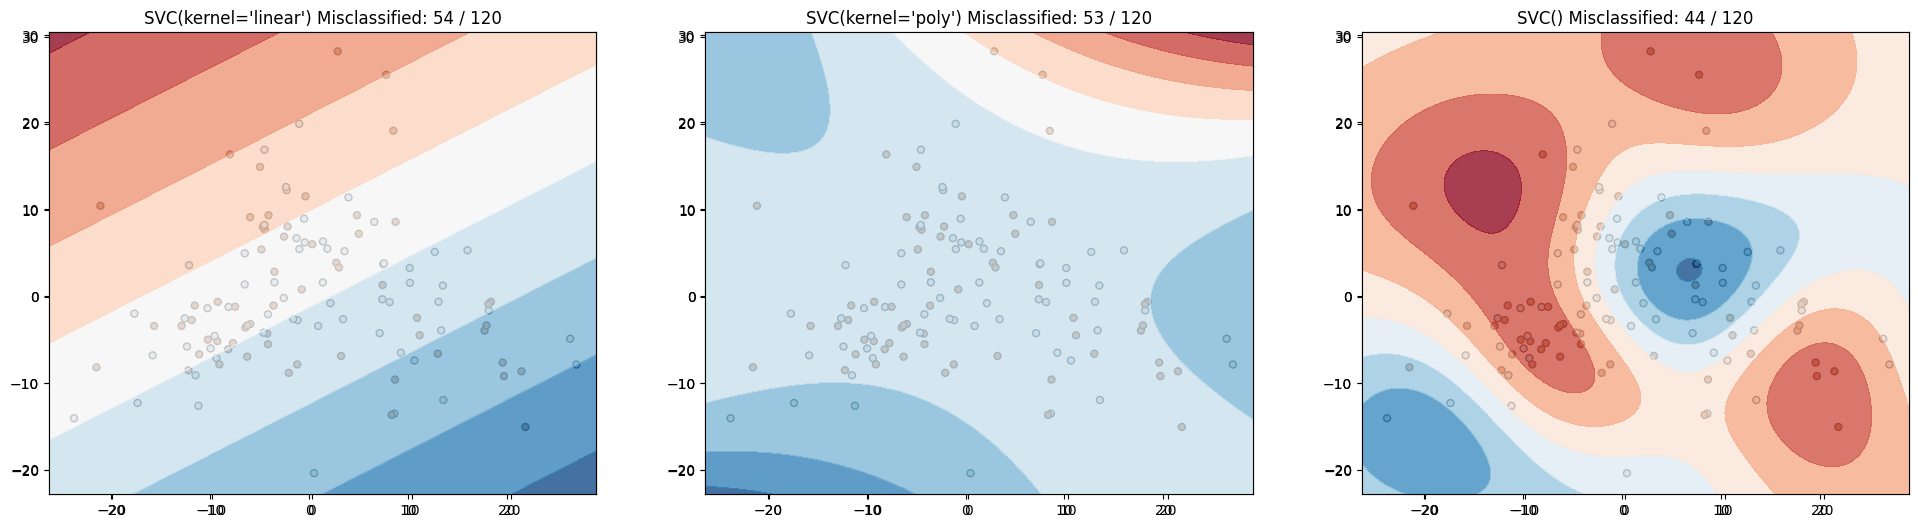

In [ ]:
# three different svc possibilities
svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

clsfs = [svmlin, svmpoly, svmrbf]

# MOET NOG AANGEPAST NAAR GOEDE INPUT
Xs = X_train_pca
Ys = y_train_list

# First make plot without classifiers:
num = 0
fig = plt.figure(figsize=(24,2*len(clsfs)))
for num in range(0,3):
    ax = fig.add_subplot(1, 3, num + 1)
    ax.scatter(Xs[:, 0], Xs[:, 1], marker='o', c=Ys,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    num += 1

num=0
# Now use the classifiers on all datasets
for clf in clsfs:
    clf.fit(Xs, Ys)
    ax = fig.add_subplot(1, 3, num + 1)
    ax.scatter(Xs[:, 0], Xs[:, 1], marker='o', c=Ys,
        s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, Xs[:, 0], Xs[:, 1])
    y_pred = clf.predict(Xs)
    t = (f"{clf} Misclassified: %d / %d" % ((Ys != y_pred).sum(), Xs.shape[0]))
    ax.set_title(t)
    num += 1


Grid search SVM

In [ ]:
degrees = [1, 3, 5]
coef0s = [0.01, 0.5, 1, 3]
slacks = [0.01, 0.5, 1, 3]
#pas op: vooral door veel en hoge degrees gaat de runtime erg omhoog

# Define parameter grid
param_grid = {
    'degree': degrees,
    'coef0': coef0s,
    'C': slacks,
}

svmlin = SVC(kernel='linear', gamma='scale')
svmrbf = SVC(kernel='rbf', gamma='scale')
svmpoly = SVC(kernel='poly', degree=3, gamma='scale')

clsfs = [svmlin, svmpoly, svmrbf]

# Perform grid search with cross-validation
for clf in clsfs:
    cv = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, cv=cv, scoring='roc_auc')
    grid_search.fit(X_train_pca, y_train_list)

    # Best hyperparameters
    print("Best parameters:",clf, grid_search.best_params_)

    # Re-train the model with the best parameters
    best_SVM = SVC(**grid_search.best_params_)
    best_SVM.fit(X_train_pca, y_train_list)

    # Evaluate the model training
    y_pred1 = best_SVM.predict(X_train_pca)
    accuracy = accuracy_score(y_train_list, y_pred1)
    print(f"training Accuracy: {accuracy}")

    # Evaluate the model validation
    y_pred = best_SVM.predict(X_val_pca)
    accuracy = accuracy_score(y_val_list, y_pred)
    print(f"Validation Accuracy: {accuracy}")

Best parameters: SVC(kernel='linear') {'C': 0.5, 'coef0': 0.01, 'degree': 1}
training Accuracy: 0.6416666666666667
Validation Accuracy: 0.4827586206896552
Best parameters: SVC(kernel='poly') {'C': 3, 'coef0': 1, 'degree': 5}
training Accuracy: 0.6666666666666666
Validation Accuracy: 0.5862068965517241
Best parameters: SVC() {'C': 1, 'coef0': 0.01, 'degree': 1}
training Accuracy: 0.6333333333333333
Validation Accuracy: 0.5172413793103449


####Random Forest

ValueError: X has 2 features, but RandomForestClassifier is expecting 4 features as input.

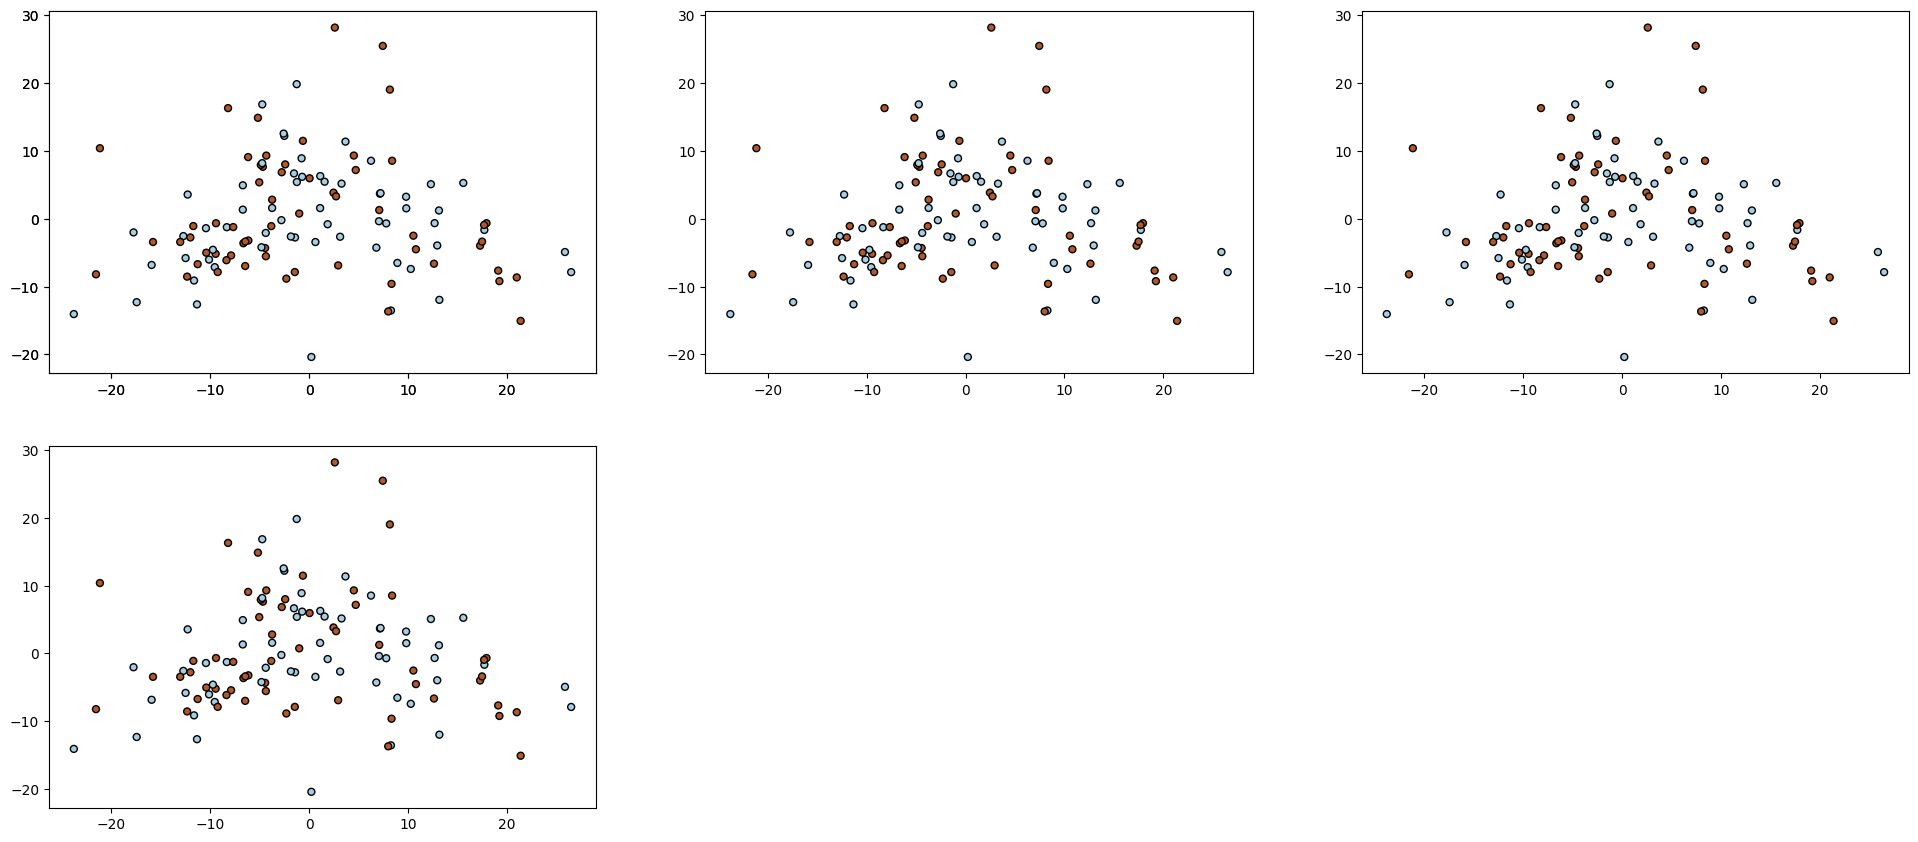

In [ ]:
from uuid import RFC_4122
# General packages
#import numpy as np
#import matplotlib.pyplot as plt
#from sklearn import datasets as ds
import sklearn as skl

# Classifiers
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score

## Vizualizing multiple Random Forest with different amount of trees
# PCA selection
Xs = X_train_pca
Ys = y_train_list
Xv = X_val_pca
Yv = y_val_list

# Lasso
# Xs = X_train_lasso
# Ys = y_train_lasso
# Xv = X_val_lasso
# Yv = y_val_lasso


# Amount of trees
n_trees = [5, 10, 25, 50]

# Different amount of trees in the RandomForest plot
clf1 = RandomForestClassifier(n_estimators=5)
clf2 = RandomForestClassifier(n_estimators=10)
clf3 = RandomForestClassifier(n_estimators=25)
clf4 = RandomForestClassifier(n_estimators=50)

clsfs = [clf1, clf2, clf3, clf4]

# First make a plot without classifiers:
fig = plt.figure(figsize=(24,4*len(clsfs)))
num = 0  # Iteration number for the subplots
for num in range(0,4):
    ax = fig.add_subplot(3, 3, num + 1)
    ax.scatter(Xs[:, 0], Xs[:, 1], marker='o', c=Ys,
            s=25, edgecolor='k', cmap=plt.cm.Paired)

# Fit the classifiers and add them to the plot
num=0
Xt=list()
Yt=list()
for n_tree in n_trees:
    # Fit trees
    clf = RandomForestClassifier(n_estimators=n_tree)
    clf.fit(Xs,Ys)
    y_pred=clf.predict(Xs)
    # Predict labels using fitted classifier

    # Make scatterplot of features
    ax = fig.add_subplot(3, 3, num + 1)
    ax.scatter(Xs[:, 0], Xs[:, 1], marker='o', c=Ys,
            s=25, edgecolor='k', cmap=plt.cm.Paired)
    colorplot(clf, ax, Xs[:,0], Xs[:,1])
    # Add overlay through colorplot function
    t=(f"{clf}, Misclass: %d / %d" % ((Ys!=y_pred).sum(), Xs.shape[0]))
    ax.set_title(t)
    num+=1

    clfs_fit.append(clf)
    Xt.append(Xs)
    Yt.append(Ys)

## Training Data
# Train model on train set
model_RF = RandomForestClassifier()
model_RF.fit(Xs, Ys)

# # Print prediction results
# predictions_RF = model_RF.predict(Xs)
# print(classification_report(Ys, predictions_RF))

# Grid parameters
param_grid_RF = {
    'n_estimators': list(range(1, 50, 2)),
    'max_features': ['sqrt', 'log2', None],
    'max_depth': [5, 6, 7, 8],
    'max_leaf_nodes': [5, 6, 7, 8],
}

# Other parameters
scoring = 'roc_auc'
cv = StratifiedKFold(n_splits=10)

grid_RF = GridSearchCV(
    RandomForestClassifier(), param_grid_RF, refit=True, verbose=1, scoring=scoring, cv=cv
)

# Fit model for grid search
grid_RF.fit(Xs, Ys)

# Best parameters after tuning
print(f"Best parameters: {grid_RF.best_params_}")
# print(f"Best estimator: {grid_RF.best_estimator_}")

# Re-train the model with the best parameters
best_RF = RandomForestClassifier(**grid_search.best_params_)
best_RF.fit(Xs, Ys)

# Evaluate the model training
y_pred1 = best_RF.predict(Xs)
accuracy = accuracy_score(Ys, y_pred1)
print(f"Training Accuracy: {accuracy}")

# Evaluate the model validation
y_pred = best_RF.predict(Xv)
accuracy = accuracy_score(Yv, y_pred)
print(f"Validation Accuracy: {accuracy}")


## Test the metrics on the used classifiers

[array([[ 1.46441042e-02,  1.16139893e+01, -6.78705649e+00,
        -2.42989268e-01],
       [-1.34797401e+01, -9.67688301e+00, -4.79891131e+00,
        -9.56073694e+00],
       [ 1.26979660e+01, -6.63715624e-01, -3.11992619e-01,
        -4.73324352e+00],
       [-1.12795088e+01, -6.70697404e+00, -9.26362751e+00,
         1.48108735e+00],
       [ 4.56899259e-02,  5.95240924e+00, -1.85594325e+00,
        -3.74144198e+00],
       [-1.27276655e+01, -2.56497082e+00,  7.51320573e+00,
         6.29930680e+00],
       [ 1.56006497e+01,  5.25968058e+00,  8.61275504e+00,
         8.63507571e-01],
       [ 1.56510806e+00,  5.44357841e+00, -6.90001678e+00,
         5.45771176e-01],
       [ 2.26943694e-01, -2.03758550e+01,  1.43986105e+01,
        -4.19539434e+00],
       [-3.82899602e+00, -1.10005981e+00, -4.72326247e+00,
         2.58613962e+00],
       [-1.77667827e+01, -2.02484510e+00,  2.28685748e+01,
        -1.47652379e+01],
       [-4.37821169e+00, -5.53719314e+00,  2.18400039e+00,
     

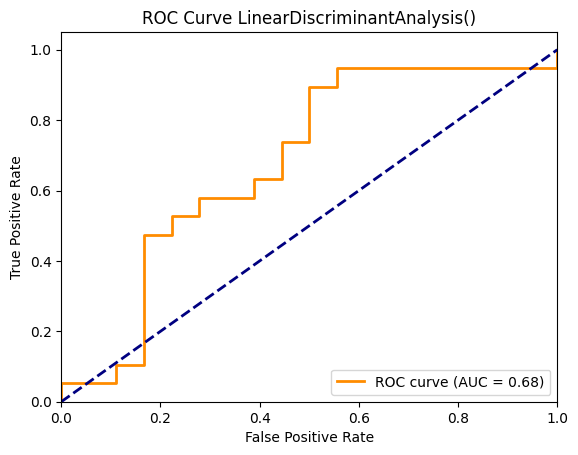

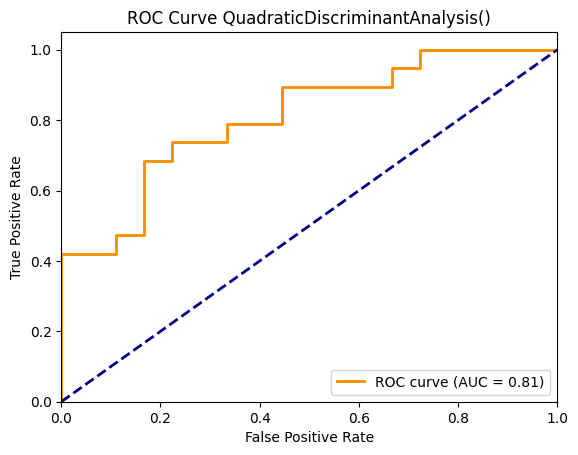

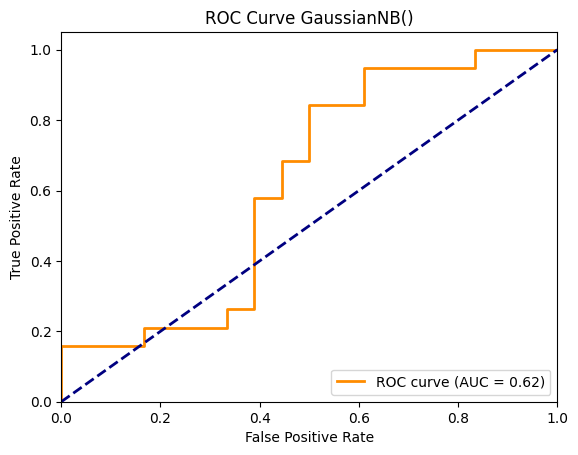

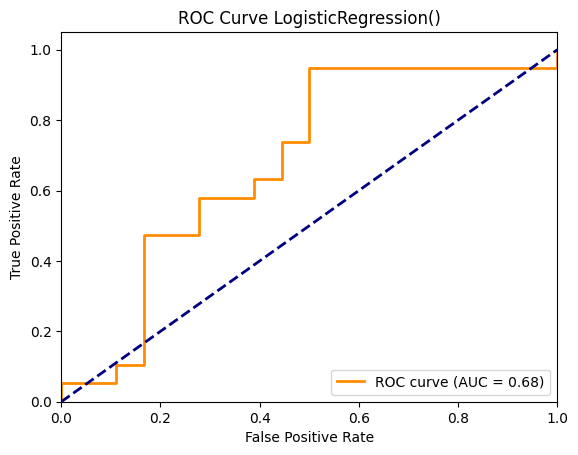

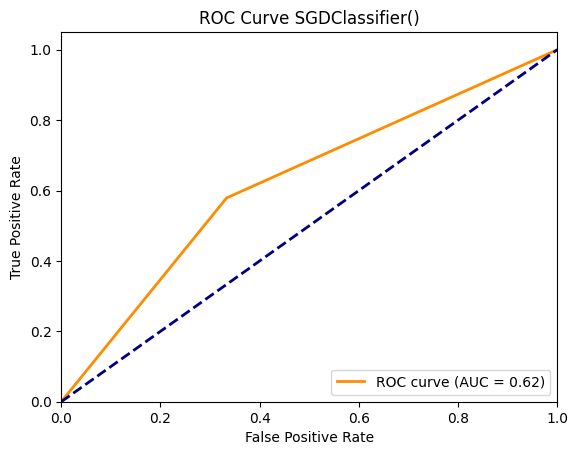

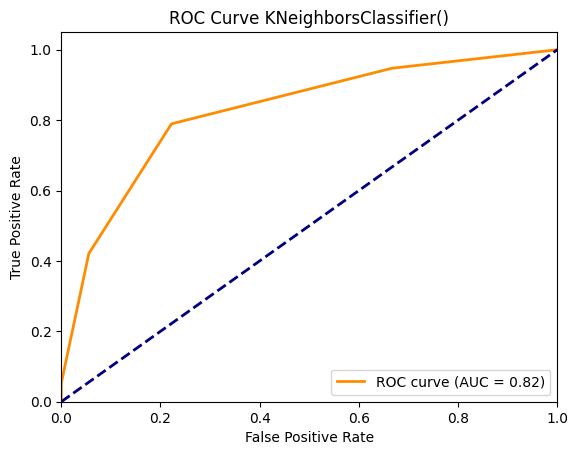

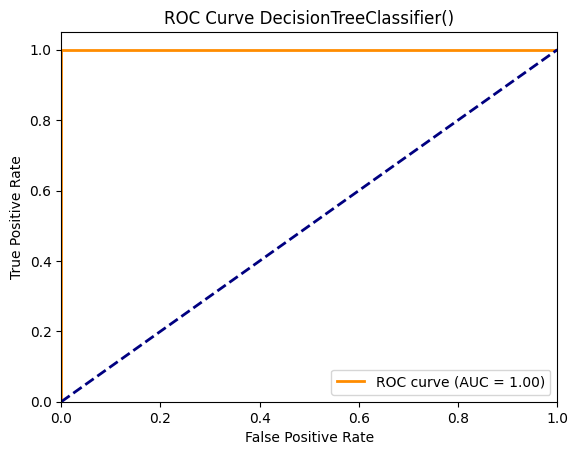

,LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),GaussianNB(),LogisticRegression(),SGDClassifier(),KNeighborsClassifier(),DecisionTreeClassifier()
auc,0.678363,0.809942,0.616959,0.678363,0.622807,0.824561,1.0
accuracy,0.594595,0.702703,0.621622,0.594595,0.621622,0.783784,1.0
F1,0.615385,0.731707,0.650000,0.615385,0.611111,0.789474,1.0
precision,0.600000,0.681818,0.619048,0.600000,0.647059,0.789474,1.0
recall,0.631579,0.789474,0.684211,0.631579,0.578947,0.789474,1.0


In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc

df_data = pd.DataFrame(data)
y_truth = df_data.iloc[:, :1]   # Classification Benign/Malignant
all_results={}

# DEZE MOET AANGEPAST NAAR WELKE CLASSIFIERS WE WILLEN TESTEN, EN MET WELKE DATA
# dit moeten alle gebruikte classifiers zijn
clfs_testing = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),GaussianNB(),
         LogisticRegression(),SGDClassifier(),KNeighborsClassifier(),DecisionTreeClassifier()]

# dit moet de juiste input zijn ipv de pca
X_input = X_test_pca
Y_input = y_test_list
X_testdata = list() # dit moet de testdata zijn, met de goed gekozen features
Y_testdata = list()
for clf in clfs_testing:
    clf.fit(X_input,Y_input)
    X_testdata.append(X_input)
    Y_testdata.append(Y_input)
print(X_testdata)

for clf, X1, Y1 in zip(clfs_testing, X_testdata, Y_testdata):
    y_pred=clf.predict(X1)

    if hasattr(clf, 'predict_proba'):
    # The first column gives the probability for class = 0, so we take
    # the second which gives the probability class = 1:
        y_score = clf.predict_proba(X1)[:, 1]
    else:
        y_score = y_pred

    # The hasattr function checks whether an object, function or package has
    # a certain attribute. This attribute can be a subfunction, or again an
    # object or function, but also things like scalars or strings.

    auc_score=metrics.roc_auc_score(Y1, y_score)
    accuracy=metrics.accuracy_score(Y1, y_pred)
    F1=metrics.f1_score(Y1,y_pred)
    precision=metrics.precision_score(Y1,y_pred)
    recall=metrics.recall_score(Y1, y_pred)
    # accuracy, AUC, f1score, precision, recall
    result = [auc_score,accuracy,F1,precision,recall]
    all_results[clf]=result

    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(Y1, y_score)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve {clf}')
    plt.legend(loc="lower right")
    plt.show()

results_pd = pd.DataFrame(all_results)
results_pd.index = ['auc','accuracy','F1','precision','recall']
results_pd
# ## transpose possible if we want the axes different
# # results_trans=results_pd.transpose()
# # results_trans